# Defining the baseline model 

----

### Objective
To define a baseline model, which is a simple and often minimalist machine learning model that serves as a starting point for solving a particular task. The baseline model will provide a reference point to evaluate the performance of more complex models.


### Baseline Models

To establish a benchmark for evaluating the performance of more complex models, I will implement three simple baseline models:

* **Random Model**: This model randomly classifies each pixel into the positive or negative class based on the overall class distribution in the dataset. While simplistic, it serves as a lower bound for performance and helps ensure that more advanced models are better than chance.

* **Threshold Classifier**: This model classifies pixels based on a fixed intensity threshold for the NIR band. Pixels with intensity values below the threshold are classified as positive, while those above are classified as negative.

* **Logistic Regression Model**: A more sophisticated approach, this model uses logistic regression to predict the class of each pixel based on its NIR intensity. By learning a probabilistic decision boundary, it provides a stronger baseline while maintaining interpretability and simplicity.

-----

### Import Libs

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from glob import glob
import glob
import random
import imageio
import imageio.v2 as imageio  # Explicitly use version 2 API

#import torch.nn as nn
#import torch
#from torchvision import transforms

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import f1_score, precision_score, recall_score
#from sklearn.metrics import jaccard_score
#from PIL import Image

import re
#import rasterio
#from rasterio.enums import Resampling

import time
from datetime import datetime

In [8]:
from tools import evaluate_random_model, plot_confusion_matrix, plot_NIR_hist_per_class

### Import Dataset
- Import folder with images
- Import folder with masks
- Create list with training and testing data

In [10]:
# Function to extract the numeric value from filenames
def numeric_sort_key(filepath):
    # Extract numbers from the filename using a regular expression
    match = re.search(r'\d+', filepath)
    # Return the integer value of the number if found, otherwise 0
    return int(match.group()) if match else 0
    
# Get all the image and mask paths and sort them numerically
folder_data_train = sorted(
    glob.glob("../5-Data_Wrangling/data_split2/train/input/*tif"),
    key=numeric_sort_key
)
folder_mask_train = sorted(
    glob.glob("../5-Data_Wrangling/data_split2/train/labels/*tif"),
    key=numeric_sort_key
)

folder_data_val = sorted(
    glob.glob("../5-Data_Wrangling/data_split2/val/input/*tif"),
    key=numeric_sort_key
)
folder_mask_val = sorted(
    glob.glob("../5-Data_Wrangling/data_split2/val/labels/*tif"),
    key=numeric_sort_key
)

folder_data_test = sorted(
    glob.glob("../5-Data_Wrangling/data_split2/test/input/*tif"),
    key=numeric_sort_key
)
folder_mask_test = sorted(
    glob.glob("../5-Data_Wrangling/data_split2/test/labels/*tif"),
    key=numeric_sort_key
)

# Assign to variables
train_image_paths = folder_data_train[:]
val_image_paths = folder_data_val[:]
test_image_paths = folder_data_test[:]

train_mask_paths = folder_mask_train[:]
val_mask_paths = folder_mask_val[:]
test_mask_paths = folder_mask_test[:]


In [11]:
# Check the number of train, val and test images
print('\nControl number of images by folder:')
print(40*'=')
input_total = len(folder_data_train)+len(folder_data_val)+len(folder_data_test)
labels_total = len(folder_mask_train)+len(folder_mask_val)+len(folder_mask_test)
print('\t\tinput: \tlabels:')
print(f'Train\t\t{len(folder_data_train)}\t{len(folder_mask_train)}\t{(len(folder_data_train)/input_total)*100:.2f}%')
print(f'Val\t\t{len(folder_data_val)}\t{len(folder_mask_val)}\t{(len(folder_data_val)/input_total)*100:.2f}%')
print(f'Test\t\t{len(folder_data_test)}\t{len(folder_mask_test)}\t{(len(folder_data_test)/input_total)*100:.2f}%')
print(40*'=')
print(f'Total\t\t{input_total}\t{labels_total}')


Control number of images by folder:
		input: 	labels:
Train		201	201	73.90%
Val		35	35	12.87%
Test		36	36	13.24%
Total		272	272


### Explore the Dataset

In [13]:
def plot_histograms(image_paths, num_samples=5):
    """
    Plot histograms for each band (R, G, B, NIR) for a given sample of images.
    """
    red_values = []
    green_values = []
    blue_values = []
    nir_values = []
    
    # Iterate over a subset of images
    for img_path in image_paths[:num_samples]:  
        image = imageio.imread(img_path)
        
        # Separate the bands
        red_values.extend(image[:, :, 0].flatten())
        green_values.extend(image[:, :, 1].flatten())
        blue_values.extend(image[:, :, 2].flatten())
        nir_values.extend(image[:, :, 3].flatten())

    # Plot histograms
    plt.figure(figsize=(16, 8))
    
    plt.subplot(2, 2, 1)
    plt.hist(red_values, bins=50, color='red', alpha=0.7)
    plt.title("Red Band Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    
    plt.subplot(2, 2, 2)
    plt.hist(green_values, bins=50, color='green', alpha=0.7)
    plt.title("Green Band Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    
    plt.subplot(2, 2, 3)
    plt.hist(blue_values, bins=50, color='blue', alpha=0.7)
    plt.title("Blue Band Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    
    plt.subplot(2, 2, 4)
    plt.hist(nir_values, bins=50, color='purple', alpha=0.7)
    plt.title("NIR Band Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()



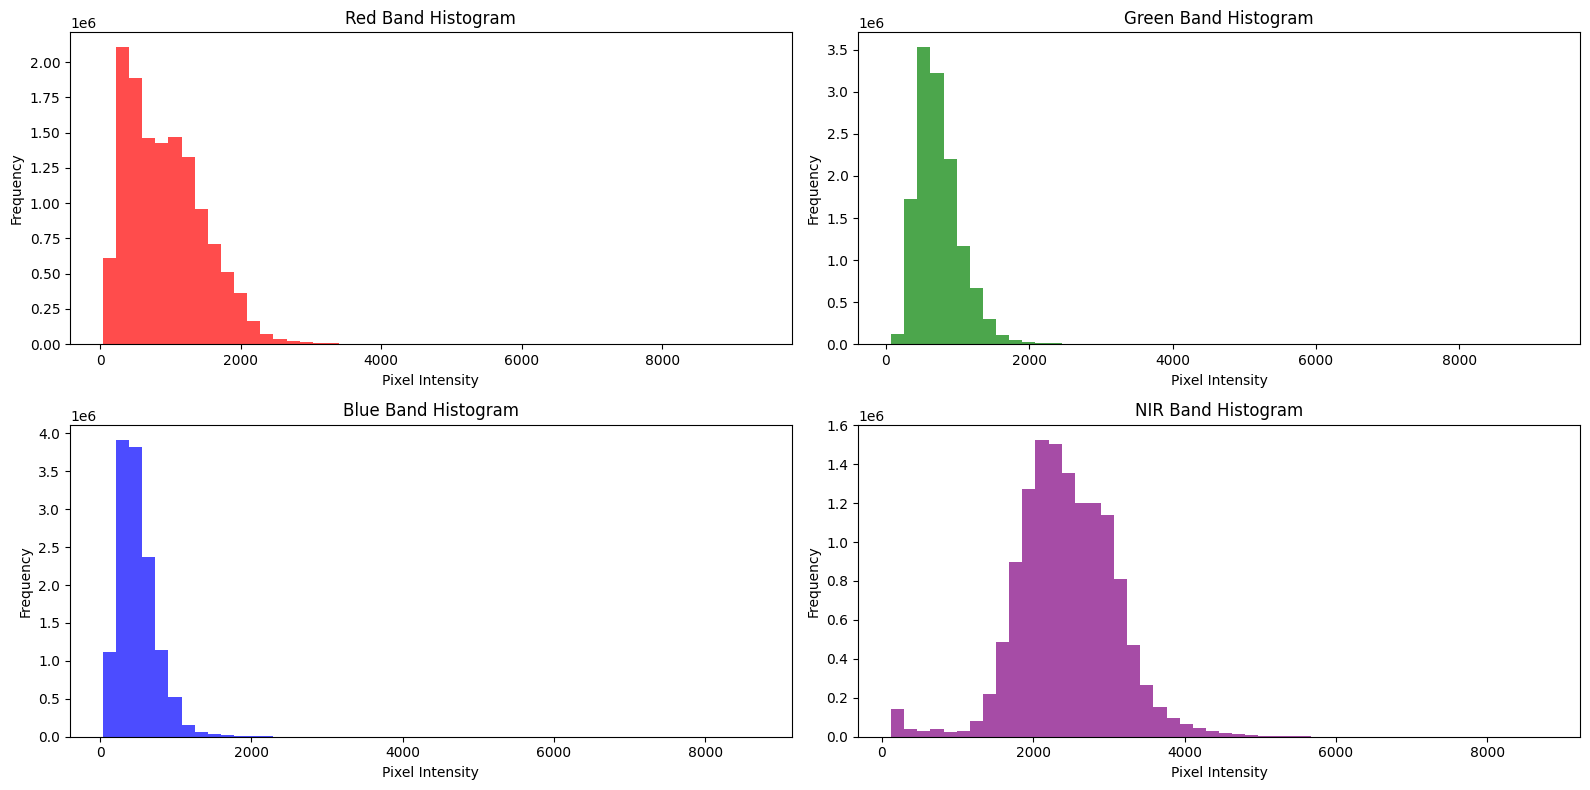

In [14]:
# Call the function with your training image paths
plot_histograms(train_image_paths, num_samples=250)

### Image statistics by band


In [16]:

def central_stats(image_paths):
    # Initialize arrays to accumulate mean, std, min and max values for each band
    mean_values = np.zeros(4)
    std_values = np.zeros(4)
    min_values = np.full(4, np.inf)
    max_values = np.full(4, -np.inf)
    
    n_pixels = 0  # Total pixel count across all images (for averaging)
    
    # Iterate over all images in the training set
    for img_path in image_paths:
        # Load the image and cast to float32 for precision
        image = imageio.imread(img_path).astype(np.float32)
        
        # Calculate the mean and std per band for this image
        mean_per_image = image.mean(axis=(0, 1))  # Mean across spatial dimensions
        std_per_image = image.std(axis=(0, 1))    # Std deviation across spatial dimensions
        
        # Accumulate the total mean and std values
        mean_values += mean_per_image
        std_values += std_per_image
            
        # Calculate and update the min and max per band
        min_per_image = image.min(axis=(0, 1))
        max_per_image = image.max(axis=(0, 1))
        for i in range(len(min_values)):
            min_values[i] = min(min_values[i], min_per_image[i])
            max_values[i] = max(max_values[i], max_per_image[i])
    
    # Average the mean and std across all images
    mean_values /= len(image_paths)
    std_values /= len(image_paths)
    
    print("Mean per band (R, G, B, NIR):", mean_values)
    print("Std deviation per band (R, G, B, NIR):", std_values)
    print("Min values per band (R, G, B, NIR):", min_values)
    print("Max values per band (R, G, B, NIR):", max_values)


In [17]:
central_stats(train_image_paths)

Mean per band (R, G, B, NIR): [ 927.75739512  740.14410416  492.39665161 2441.67961341]
Std deviation per band (R, G, B, NIR): [420.10468167 257.58737858 200.92512581 500.59008288]
Min values per band (R, G, B, NIR): [ 38.  74.  35. 123.]
Max values per band (R, G, B, NIR): [9380. 9224. 8710. 8791.]


------

## 1- Random Model

This model randomly classifies each pixel into the positive or negative class based on the overall class distribution in the dataset. While simplistic, it serves as a lower bound for performance and helps ensure that more advanced models are better than chance.

In [21]:
def compute_positive_class_probability_per_mask(mask_paths):
    """
    Compute the positive class probability (1) for each mask individually.
    Args:
        mask_paths: List of paths to the training masks.
    Returns:
        List of positive class probabilities, one for each mask.
    """
    positive_probs = []

    for mask_path in mask_paths:
        mask = imageio.imread(mask_path)
        total_pixels = mask.size
        positive_pixels = np.sum(mask)  # Assuming positive class is represented by 1
        positive_prob = positive_pixels / total_pixels
        positive_probs.append(positive_prob)

    return positive_probs

def random_model_prediction_per_mask(test_image_paths, mask_positive_probs):
    """
    Generate random predictions for test images based on the positive class probability of each corresponding mask.
    Args:
        test_image_paths: List of paths to the test images.
        mask_positive_probs: List of positive class probabilities for each mask.
    Returns:
        Random predictions as a list of NumPy arrays, one for each test image.
    """
    random_preds = []
    np.random.seed(23)

    for img_path, positive_prob in zip(test_image_paths, mask_positive_probs):
        mask_shape = imageio.imread(img_path).shape[:2]  # Assuming mask has same height and width as input image
        random_mask = np.random.choice(
            [0, 1], size=mask_shape, p=[1 - positive_prob, positive_prob]
        )
        random_preds.append(random_mask)

    return random_preds


----------------------------------------------------------------------
TP:722	TN:2148850	FP:40594		FN:169130
----------------------------------------------------------------------


Accuracy:     0.9111	               (TP + TN) / (TP + TN + FP + FN)
Recall:       0.0043	                      TP / (TP + FN)
Specificity:  0.9815	                      TN / (TN + FP)
Precision:    0.0175	                      TP / (TP + FP)
F1-Score:     0.0068	    (2*precision*recall) / (precision + recall)
IoU:          0.0034	                      TP / (TP + FN + FP)





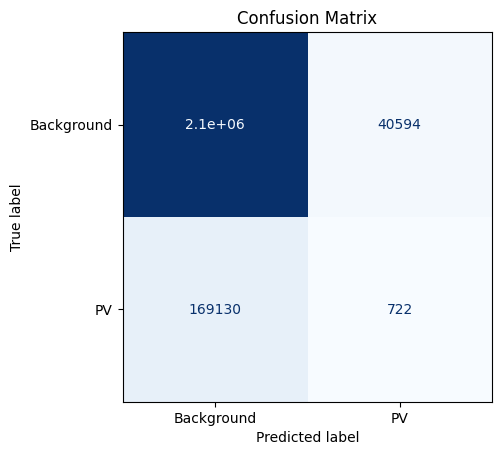

In [22]:
# Compute positive class probabilities for each training mask
mask_positive_probs = compute_positive_class_probability_per_mask(train_mask_paths)

# Generate random predictions using per-mask probabilities
random_preds = random_model_prediction_per_mask(test_image_paths, mask_positive_probs[:len(test_image_paths)])

# Evaluate and display the Confusion Matrix
cm, all_masks, all_preds = evaluate_random_model(test_mask_paths, random_preds)
plot_confusion_matrix(cm)


### Results:
The low performance of the Random Model is expected as it relies on chance, guided by the class distribution:
- Low Recall (0.0043): The rare positive class leads to few correct predictions.
- High Specificity (0.9815): The negative class dominates, so most negatives are correctly predicted.
- Low Precision (0.0175): Most positive predictions are incorrect due to random guessing.
- Low F1-Score (0.0068): Reflects the poor balance between precision and recall.
- IoU (0.0034): Minimal overlap between predictions and ground truth.


## 2- Threshold Classifier

This model classifies pixels based on a fixed intensity threshold for the NIR band. Pixels with intensity values below the threshold are classified as positive, while those above are classified as negative.

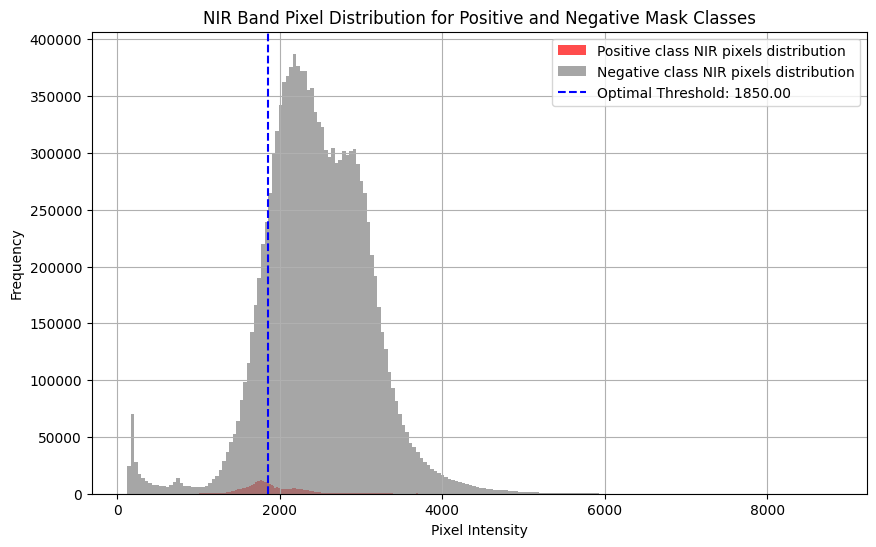

Optimal Threshold: 1850.00
Best F1 Score: 0.1375
13,172,736 pixels considered from 201 images


1850

In [26]:
plot_NIR_hist_per_class(train_image_paths, train_mask_paths, num_samples=250)

In [27]:
def threshold_classifier_prediction(image_paths, threshold):
    """
    Classify pixels using a fixed threshold on the NIR band.
    """
    predictions = []
    
    for img_path in image_paths:
        image = imageio.imread(img_path)
        nir_band = image[:, :, 3]  # Extract the NIR band
        prediction = (nir_band <= threshold).astype(int)  # Apply threshold
        predictions.append(prediction)
    
    return predictions



----------------------------------------------------------------------
TP:74114	TN:2139055	FP:50389		FN:95738
----------------------------------------------------------------------


Accuracy:     0.9381	               (TP + TN) / (TP + TN + FP + FN)
Recall:       0.4363	                      TP / (TP + FN)
Specificity:  0.9770	                      TN / (TN + FP)
Precision:    0.5953	                      TP / (TP + FP)
F1-Score:     0.5036	    (2*precision*recall) / (precision + recall)
IoU:          0.3365	                      TP / (TP + FN + FP)





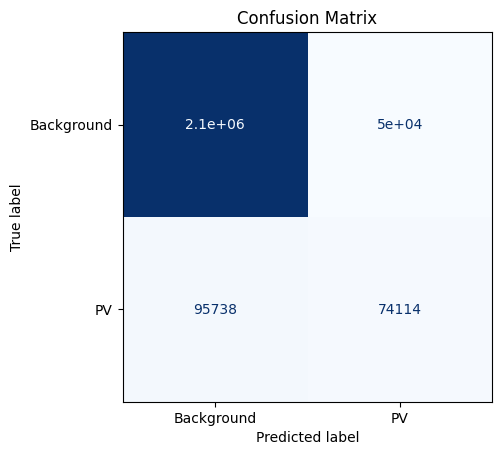

In [28]:
# Generate predictions for the test dataset
threshold = 1850
threshold_predictions = threshold_classifier_prediction(test_image_paths, threshold)

# Evaluate the model
cm, masks_flat, preds_flat = evaluate_random_model(test_mask_paths, threshold_predictions)

# Plot the confusion matrix and metrics
plot_confusion_matrix(cm)

### Results:
Compared to the Random Model, the Threshold Classifier shows notable improvement across all metrics, especially Recall and F1-Score. 
- Accuracy (0.9381): High, due to the dominance of the background class.
- Recall (0.4363): Improved detection of 43.63% of PV pixels.
- Specificity (0.9770): Correctly identified 97.70% of background pixels.
- Precision (0.5953): 59.53% of PV predictions were correct.
- F1-Score (0.5036): Balanced measure of precision and recall.
- IoU (0.3365): Indicates fair overlap between predictions and true positives.




## 3- Logistic Regression Model

This model uses logistic regression to predict the class of each pixel based on its NIR intensity. By learning a probabilistic decision boundary, it provides a stronger baseline while maintaining interpretability and simplicity.

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

def prepare_data_for_logistic_regression(image_paths, mask_paths, band_index=3):
    """
    Prepare flattened NIR band and mask data for logistic regression.
    """
    X = []
    y = []

    for img_path, mask_path in zip(image_paths, mask_paths):
        image = imageio.imread(img_path)[:, :, band_index]
        mask = imageio.imread(mask_path)

        # Force binary encoding for the mask
        mask = (mask > 0).astype(int)
        

        # Flatten NIR band and mask values
        X.extend(image.flatten())
        y.extend(mask.flatten())

    return np.array(X).reshape(-1, 1), np.array(y)


----------------------------------------------------------------------
TP:104260	TN:2088443	FP:101001		FN:65592
----------------------------------------------------------------------


Accuracy:     0.9294	               (TP + TN) / (TP + TN + FP + FN)
Recall:       0.6138	                      TP / (TP + FN)
Specificity:  0.9539	                      TN / (TN + FP)
Precision:    0.5079	                      TP / (TP + FP)
F1-Score:     0.5559	    (2*precision*recall) / (precision + recall)
IoU:          0.3849	                      TP / (TP + FN + FP)





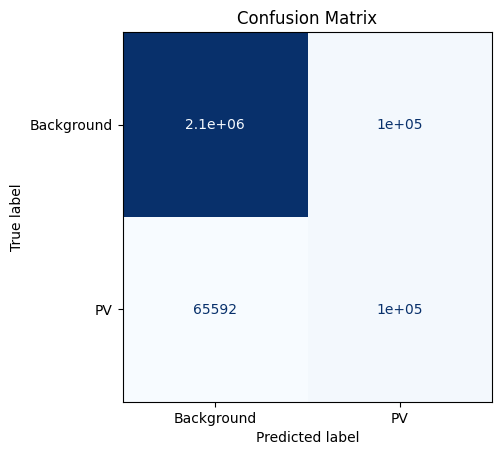

In [42]:
# Prepare training data
X_train, y_train = prepare_data_for_logistic_regression(train_image_paths, train_mask_paths)

# Prepare testing data
X_test, y_test = prepare_data_for_logistic_regression(test_image_paths, test_mask_paths)

# Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression Model with balanced class weights
logistic_model = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced')
logistic_model.fit(X_train_scaled, y_train)

# Predict probabilities
y_pred_proba = logistic_model.predict_proba(X_test_scaled)[:, 1]

# Adjust threshold
threshold = 0.6  # Adjust threshold based on analysis
y_pred = (y_pred_proba > threshold).astype(int)

# Evaluate predictions
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)



### Results:
The Logistic Regression model with a threshold of 0.6 outperforms the Random and Threshold models by achieving a better balance between precision and recall, making it a more effective detector for PV regions.

Evaluation Metrics:

- Accuracy (0.9294): ~93% of all pixels were correctly classified, though class imbalance limits its interpretability.
- Recall (0.6138): ~61% of positive pixels (PV) were correctly identified, showing improved sensitivity.
- Specificity (0.9539): ~95% of background pixels were accurately classified, indicating good False Positive control.
- Precision (0.5079): ~51% of predicted PV pixels were correct, reflecting better but still imperfect precision.
- F1-Score (0.5559): A balanced score of 55.6%, highlighting a reasonable trade-off between precision and recall.
- IoU (0.3849): ~38.5% overlap between predicted and actual PV pixels, suggesting decent localization accuracy.
